In [1]:
import numpy as np
import MDAnalysis as md

## Which ions sit closest to the surface

In [4]:
cl_atoms = universe.select_atoms("resname Cl")
na_atoms = universe.select_atoms("resname Na")
c_atoms = universe.select_atoms("resname GRA")

In [6]:
cl_c_distances = []
na_c_distances = []

import MDAnalysis.analysis as ad

c_positions = np.array([atom.position for atom in c_atoms])
cl_positions = np.array([atom.position for atom in cl_atoms])
na_positions = np.array([atom.position for atom in na_atoms])

In [69]:
box_dimensions = universe.dimensions
box_centre = box_dimensions[0:3]/2

In [70]:
from MDAnalysis.analysis.density import density_from_Universe

In [43]:
D = density_from_Universe(universe, delta=1.0, atomselection="resname Cl", xdim=box_dimensions[0], ydim=box_dimensions[1], zdim=box_dimensions[2], gridcenter=box_centre)

In [49]:
x_y_mean = np.mean(D.grid, axis=(0,1))

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
z_axis = np.linspace(0, box_dimensions[2], 100)

Text(0.5, 1.0, 'Density Map of Cl Ions')

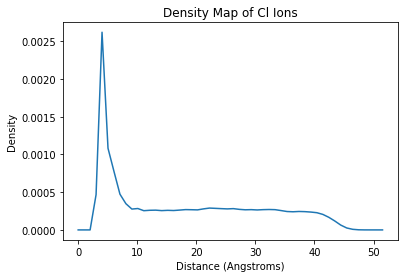

In [62]:
plt.plot(z_axis[:52], x_y_mean[:52])
plt.ylabel("Density")
plt.xlabel("Distance (Angstroms)")
plt.title("Density Map of Cl Ions")

In [74]:
def plot_densities():
    cl_density = density_from_Universe(universe, delta=1.0, atomselection="resname Cl", gridcenter=box_centre, xdim=box_dimensions[0], ydim=box_dimensions[1], zdim=box_dimensions[2])
    na_density = density_from_Universe(universe, delta=1.0, atomselection="resname Na", gridcenter=box_centre, xdim=box_dimensions[0], ydim=box_dimensions[1], zdim=box_dimensions[2])
    cl_density.export("chlorine.dx", type="double")
    na_density.export("sodium.dx", type="double")
    cl_mean = np.mean(cl_density.grid, axis=(0,1))
    na_mean = np.mean(na_density.grid, axis=(0,1))
    z_axis = np.linspace(0, box_dimensions[2]/10, 100)
    plt.plot(z_axis, cl_mean, '-')
    plt.plot(z_axis, na_mean, ':')
    plt.title("Ion Density (Sodium Chloride at 0.5M)")
    plt.xlabel("z-distance (nm)")
    plt.ylabel("⍴")
    
    

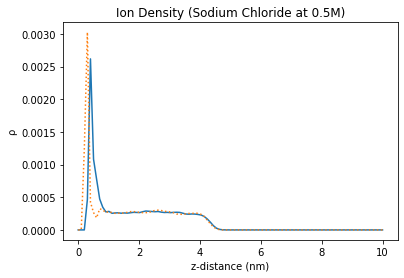

In [75]:
plot_densities()

## Residence Time

Residence time would be the time each ion spends within the height of the double layer. Once we have computed these values, we just sum the time steps that are non-zero for those ions.

In [87]:
# Modify this distance to reflect the height of the double layer
distance_limit = 10

In [2]:
def select_atoms_in_residence():
    cl_atoms = universe.select_atoms("resname Cl and prop z <={0}".format(4), updating=True)
    na_atoms = universe.select_atoms("resname Na and prop z <={0}".format(3), updating=True)
    return {"cl_atoms": cl_atoms, "na_atoms": na_atoms}
    

In [37]:
import statistics

def fetch_resid(atom_obj):
    return str(atom_obj).split("resid ")[1].split(" and")[0]



def calculate_residence_time(positions, trajectories):
    number_of_atoms_per_timeframe = {"time": [], "cl":[], "na":[]}
    times =[]
    atom_times = {}
    # In picoseconds
    time_increment = 0.002
    """ We iterate over frames here. Atoms may move in and out of the region. Frames change at 0.5ps
    on every iteration. If an atom is in frame 1, it might not be in present in the subsequent frames
    until it returns later in the simulation. """
    for frame, ts in enumerate(universe.trajectory):
        atoms_in_residence = select_atoms_in_residence()
        number_of_atoms_per_timeframe["cl"].append(len(atoms_in_residence["cl_atoms"]))
        number_of_atoms_per_timeframe["na"].append(len(atoms_in_residence["na_atoms"]))
        number_of_atoms_per_timeframe["time"] = 0.002*frame
        for atom in list(atoms_in_residence["cl_atoms"]):
            atom_resid = fetch_resid(atom)
            # If an atom has been in the box earlier, 
            # it's presence would have been recorded in the dictionary
            if atom_resid in atom_times:
                time_spent = atom_times[atom_resid]["time_spent"] + time_increment
                atom_times[atom_resid] = {"time_spent": time_spent, "type": 'cl'}
            else:
                atom_times[atom_resid] = {"time_spent": time_increment, "type": 'cl'}

        for atom in list(atoms_in_residence["na_atoms"]):
            atom_resid = fetch_resid(atom)

            if atom_resid in atom_times:
                time_spent = atom_times[atom_resid]["time_spent"] + time_increment
                atom_times[atom_resid] = {"time_spent": time_spent, "type": 'na'}
            else:
                atom_times[atom_resid] = {"time_spent": time_increment, "type": 'na'}
    
    df_list = []
    for key, data in atom_times.items():
        df_list.append({"id": key, "time_spent": data["time_spent"], "type":data["type"]})
        
    df = pd.DataFrame(df_list)
    cl_residences = df[df["type"] == 'cl']
    na_residences = df[df["type"] == 'na']
    print ("Mean Number of Cl atoms/timeframe", statistics.mean(number_of_atoms_per_timeframe["cl"]))
    print ("Mean Number of Na atoms/timeframe", statistics.mean(number_of_atoms_per_timeframe["na"]))
    print ("Variance of Cl atoms/timeframe", statistics.variance(number_of_atoms_per_timeframe["cl"]))
    print ("Variance of Na atoms/timeframe", statistics.variance(number_of_atoms_per_timeframe["na"]))
    print ("Cl atoms in 0.5/1/1.5M concentration were in residence for {0} ps on average".format(cl_residences["time_spent"].mean()))
    print ("Na atoms in 0.5/1/1.5M concentration were in residence for {0} ps on average".format(na_residences["time_spent"].mean()))

In [38]:
import pandas as pd

directories = ["0.5M", "1M", "1.5M"]

for directory in directories:
    print ("Directory used:", directory)
    
    parameters = "../{0}/nvt_10ns.gro".format(directory)
    trajectories = "../{0}/nvt_10ns.xtc".format(directory)
    
    universe = md.Universe(parameters, trajectories)
    
    calculate_residence_time(parameters, trajectories)
    



Directory used: 0.5M
Mean Number of Cl atoms/timeframe 1.3332333383330834
Mean Number of Na atoms/timeframe 3.5011249437528122
Variance of Cl atoms/timeframe 1.3192999900005
Variance of Na atoms/timeframe 3.0511112344382783
Cl atoms in 0.5/1/1.5M concentration were in residence for 1.3332999999999964 ps on average
Na atoms in 0.5/1/1.5M concentration were in residence for 3.6855789473682146 ps on average
Directory used: 1M
Mean Number of Cl atoms/timeframe 2.60301984900755
Mean Number of Na atoms/timeframe 5.32038398080096
Variance of Cl atoms/timeframe 2.5547988800559973
Variance of Na atoms/timeframe 4.541848972551373
Cl atoms in 0.5/1/1.5M concentration were in residence for 1.334948717948713 ps on average
Na atoms in 0.5/1/1.5M concentration were in residence for 3.08443478260855 ps on average
Directory used: 1.5M
Mean Number of Cl atoms/timeframe 4.261086945652718
Mean Number of Na atoms/timeframe 7.288585570721464
Variance of Cl atoms/timeframe 3.8448301984900755
Variance of Na a

### 0.5M - Na, Cl in that order

In [28]:
T = 0.3/(6*(70/15000))

In [29]:
T

10.714285714285712

In [14]:
T = 0.4/(6*(75/15000))

In [15]:
T

13.333333333333334

1M - Na, Cl

In [26]:
0.3/(6*(55/15000))

13.636363636363637

In [27]:
0.4/(6*(75/15000))

13.333333333333334

1.5M

In [30]:
0.3/(6*(40/15000))

18.75

In [31]:
0.4/(6*(70/15000))

14.285714285714285